# Summarizing PacBio `ccs` output
Example of summarizing the output of the PacBio `ccs` program (see [here](https://github.com/PacificBiosciences/ccs) for details on `ccs`).

These summaries are useful after you have run `ccs` on subreads files to create BAM CCS files, and then converted these BAM files to FASTQ files.
For the example here, a BAM CCS file and the report file was created using `ccs` version 3.1.0 with a command like the following:

    ccs --minLength 50 --maxLength 5000 \
        --minPasses 3  --minPredictedAccuracy 0.999 \
        --reportFile lib-1_report.txt \
        --polish --numThreads 16 \
        lib-1_subreads.bam lib-1_ccs.bam
        
The BAM CCS file was then converted to a FASTQ file using [samtools](http://www.htslib.org/) with flags to retain the number of passes (`np`) and read quality (`rq`) flags:

    samtools bam2fq -T np,rq lib-1_ccs.bam > lib-1_ccs.fastq
    
Everything that follows simply summarizes the report and FASTQ files created in this manner.

## Set up for analysis
Import necessary Python modules:

In [1]:
import warnings

import pandas as pd

import alignparse.ccs

Hide warnings that clutter output:

In [2]:
warnings.simplefilter('ignore')

## Data frame defining `ccs` output
Create a data frame giving the `ccs` report file and the CCS FASTQ file for each run:

In [3]:
run_names = ['recA_lib-1', 'recA_lib-2', 'vep_pilot']
ccs_dir = 'input_files'

ccs_df = pd.DataFrame(
            {'name': run_names,
             'report': [f"{ccs_dir}/{name}_report.txt" for name in run_names],
             'fastq': [f"{ccs_dir}/{name}_ccs.fastq" for name in run_names]
             })

ccs_df

,name,report,fastq
0,recA_lib-1,input_files/recA_lib-1_report.txt,input_files/recA_lib-1_ccs.fastq
1,recA_lib-2,input_files/recA_lib-2_report.txt,input_files/recA_lib-2_ccs.fastq
2,vep_pilot,input_files/vep_pilot_report.txt,input_files/vep_pilot_ccs.fastq


## Create a Summaries object
Create an `alignparse.ccs.Summaries` object for each run:

In [4]:
summaries = alignparse.ccs.Summaries(ccs_df)

for summary in summaries.summaries:
    print(summary.name)

recA_lib-1
recA_lib-2
vep_pilot


## Plot the ZMW stats
Analyze the stats on how many ZMWs (zero mode wavelengths) produced CCSs:

In [5]:
summaries.zmw_stats()

,name,status,number,fraction
0,recA_lib-1,Success -- CCS generated,98,0.6125
1,recA_lib-1,Failed -- Not enough full passes,38,0.2375
2,recA_lib-1,Failed -- CCS below minimum predicted accuracy,23,0.1437
3,recA_lib-1,Failed -- No usable subreads,1,0.0063
4,recA_lib-1,Failed -- Other reason,0,0.0000
5,recA_lib-2,Success -- CCS generated,100,0.6410
6,recA_lib-2,Failed -- Not enough full passes,36,0.2308
7,recA_lib-2,Failed -- CCS below minimum predicted accuracy,20,0.1282
8,recA_lib-2,Failed -- No usable subreads,0,0.0000
9,recA_lib-2,Failed -- Other reason,0,0.0000


Plot these stats:

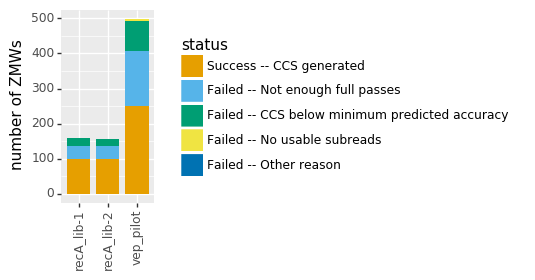

In [6]:
p = summaries.plot_zmw_stats()
_ = p.draw()

## Plot CCS stats
Analyze the stats on the CCSs.
We can get a data frame of various stats for all CCSs.
For instance, length:

In [7]:
summaries.ccs_stats('length').head(n=5)

,name,length
0,recA_lib-1,1344
1,recA_lib-1,1342
2,recA_lib-1,1342
3,recA_lib-1,1344
4,recA_lib-1,1342


Or number of subread passes:

In [8]:
summaries.ccs_stats('passes').tail(n=5)

,name,passes
443,vep_pilot,10
444,vep_pilot,101
445,vep_pilot,19
446,vep_pilot,18
447,vep_pilot,19


Since these data frames are very large when there are many CCSs, it's most convenient just to summarize with histograms:

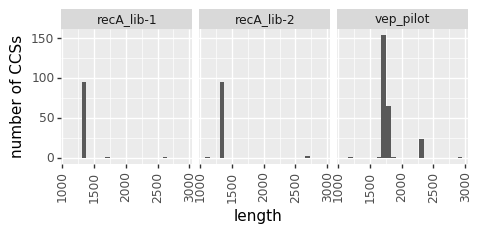

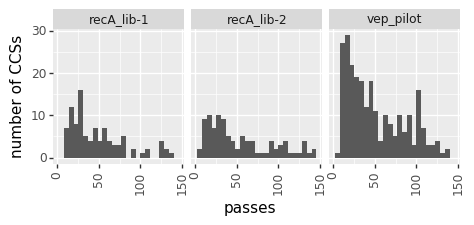

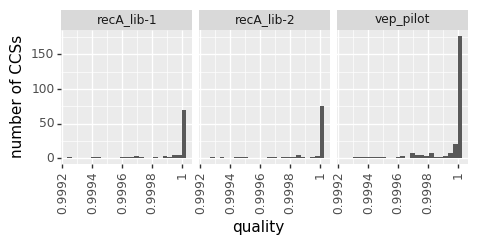

In [9]:
for stat in ['length', 'passes', 'quality']:
    p = summaries.plot_ccs_stats(stat)
    _ = p.draw()